<a href="https://colab.research.google.com/github/fireball412/colab_experiments/blob/main/keras_frsky_voltage_current_throttle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Simple TensorFlow Model for OpenTX Telemetry

script adapted from TinyML code example

## Configure Defaults

In [2]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [ ]:
! pip install tensorflow==2.4.0rc0

Import Dependencies

In [1]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset

### 1. Import Data

In [3]:
#for local file upload

#from google.colab import files 
#uploaded = files.upload()

In [4]:
import pandas as pd 
import io 

#for local file upload instead of github
#df = pd.read_csv(io.BytesIO(uploaded['Explorer-2020-11-28.csv'])) 

url = 'https://raw.githubusercontent.com/fireball412/colab_experiments/main/Explorer-2020-11-28.csv'
df = pd.read_csv(url)

print(df)


             Date          Time  RSSI(dB)  ...  SH                 LSW  TxBat(V)
0      2020-11-28  13:12:43.310         0  ...  -1  0x0000000000000000      10.0
1      2020-11-28  13:12:43.380         0  ...  -1  0x0000000000000000      10.0
2      2020-11-28  13:12:43.480         0  ...  -1  0x0000000000000000      10.0
3      2020-11-28  13:12:43.580         0  ...  -1  0x0000000000000000      10.0
4      2020-11-28  13:12:43.680         0  ...  -1  0x0000000000000000      10.0
...           ...           ...       ...  ...  ..                 ...       ...
16932  2020-11-28  18:27:36.930         0  ...  -1  0x0000000000000000      10.0
16933  2020-11-28  18:27:37.030         0  ...  -1  0x0000000000000000      10.0
16934  2020-11-28  18:27:37.130         0  ...  -1  0x0000000000000000      10.0
16935  2020-11-28  18:27:37.230         0  ...  -1  0x0000000000000000      10.0
16936  2020-11-28  18:27:37.330         0  ...  -1  0x0000000000000000      10.0

[16937 rows x 26 columns]


https://towardsdatascience.com/extract-rows-columns-from-a-dataframe-in-python-r-678e5b6743d6

In [5]:
print(df.iloc[0])

Date                2020-11-28
Time              13:12:43.310
RSSI(dB)                     0
RxBt(V)                      0
Cels(V)                      0
Curr(A)                      0
Cap(mAh)                  1378
Rud                         -2
Ele                          2
Thr                      -1021
Ail                         11
S1                        -732
S2                         341
S3                         379
LS                        -450
RS                        -135
SA                           0
SB                           0
SC                           0
SD                           0
SE                           0
SF                           1
SG                           0
SH                          -1
LSW         0x0000000000000000
TxBat(V)                    10
Name: 0, dtype: object


[-1.022 -1.022 -1.022 ... -1.018 -1.018 -1.018]
[0.005 0.005 0.005 ... 0.002 0.002 0.002]
[0.007 0.007 0.008 ... 1.362 1.362 1.362]
[1.229 1.229 1.229 ... 1.117 1.117 1.117]


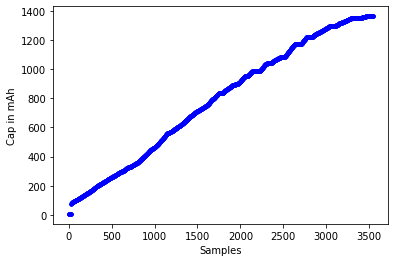

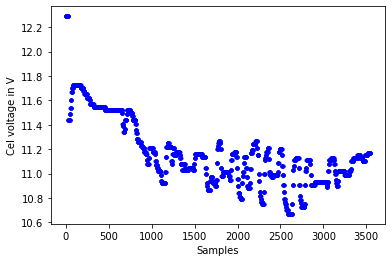

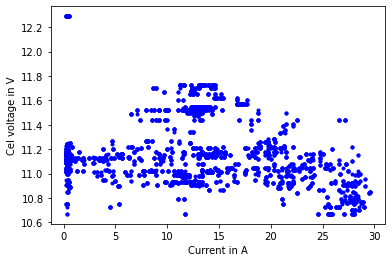

KeyboardInterrupt: ignored

In [171]:
#select data for modelling
INDEX_START=2385
INDEX_STOP=5931
#INDEX_STOP=15000
SAMPLES=INDEX_STOP-INDEX_START

#scaling for telemetry data to get close to 1
SCALE_THROTTLE=1000
SCALE_CUR=100
SCALE_CAP=1000
SCALE_VOL=10
SAMPLE_RATE=0.1

#throttle 
thr_values=df.iloc[INDEX_START:INDEX_STOP,9]
thr_values=thr_values.to_numpy()/SCALE_THROTTLE 
print(thr_values)

#current
cur_values=df.iloc[INDEX_START:INDEX_STOP,5]
cur_values=cur_values.to_numpy()/SCALE_CUR 
print(cur_values)

#cap(mAh)
cap_values=df.iloc[INDEX_START:INDEX_STOP,6]
cap_values=cap_values.to_numpy()/SCALE_CAP 
print(cap_values)

#cels(V)
cel_values=df.iloc[INDEX_START:INDEX_STOP,4]
cel_values=cel_values.to_numpy()/SCALE_VOL 
print(cel_values)

# Plot capacity
plt.plot(cap_values*SCALE_CAP, 'b.')
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()

# Plot voltage
plt.plot(cel_values*SCALE_VOL, 'b.')
plt.xlabel('Samples')
plt.ylabel('Cel voltage in V')
plt.show()

#shuffle data to avoid split of train,validate and test according to flight time
temp = list(zip(cur_values, cap_values, cel_values)) 
np.random.shuffle(temp) 
cur_values, cap_values, cel_values = zip(*temp)

cur_values=np.array(cur_values)
cap_values=np.array(cap_values)
cel_values=np.array(cel_values)


#define data for modelling
x_values=np.vstack((cur_values,cap_values))
x_values=np.transpose(x_values)
y_values=cel_values


# Plot vol vs. cur
plt.plot(x_values[:,0]*SCALE_CUR, y_values*SCALE_VOL, 'b.')
plt.xlabel('Current in A')
plt.ylabel('Cel voltage in V')
plt.show()

# Plot vol vs. cap
plt.plot(x_values[:,1]*SCALE_CAP, y_values*SCALE_VOL, 'b.')
plt.xlabel('Cap in mAh')
plt.ylabel('Cel voltage in V')
plt.show()

# Plot Cap vs. cur
plt.plot(x_values[:,1]*SCALE_CAP, x_values[:,0]*SCALE_CUR, 'b.')
plt.xlabel('Cap in mAh')
plt.ylabel('Current in A')
plt.show()



 

### 2. Split the Data
The data is split as follows:
Training: 60%
Validation: 20%
Testing: 20%

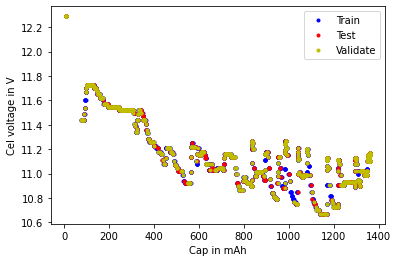

In [172]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
#x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

#x_train=x_values[:,:TRAIN_SPLIT]
#x_test=x_values[:,TRAIN_SPLIT:TEST_SPLIT]
#x_validate=x_values[:,TEST_SPLIT:]

x_train=x_values[:TRAIN_SPLIT,:]
x_test=x_values[TRAIN_SPLIT:TEST_SPLIT,:]
x_validate=x_values[TEST_SPLIT:,:]

#y_train=y_values[:,:TRAIN_SPLIT]
#y_test=y_values[:,TRAIN_SPLIT:TEST_SPLIT]
#y_validate=y_values[:,TEST_SPLIT:]

# Plot vol vs. cap
plt.plot(x_values[:,1]*SCALE_CAP, y_values*SCALE_VOL, 'b.', label="Train")
plt.plot(x_test[:,1]*SCALE_CAP, y_test*SCALE_VOL, 'r.', label="Test")
plt.plot(x_validate[:,1]*SCALE_CAP, y_validate*SCALE_VOL, 'y.', label="Validate")
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cel voltage in V')
plt.show()





## Training



### 1. Design the model

We're going to build a simple neural network model that will take an input value (in this case throttle) and use it to predict a numeric output value (current). This type of problem is called a regression. It will use layers of neurons to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our x value) and runs it through 16 neurons. Based on this input, each neuron will become activated to a certain degree based on its internal state (its weight and bias values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our y value.

Note: To learn more about how neural networks function, you can explore the Learn TensorFlow codelabs.

The code in the following cell defines our model using Keras, TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we compile it, specifying parameters that determine how it will be trained:

In [159]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(2,)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])


In [137]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


### 2. Train the Model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an _epoch_. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. Each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 200 _epochs_, with 64 pieces of data in each _batch_. We also pass in some data for _validation_. As you will see when you run the cell, training can take a while to complete:

In [160]:
# Train the model
history = model.fit(x_train, y_train, epochs=200, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model.save(MODEL_TF)


Epoch 1/200
34/34 [==============================] - 1s 7ms/step - loss: 2.1164 - mae: 1.4410 - val_loss: 1.1739 - val_mae: 1.0806
Epoch 2/200
34/34 [==============================] - 0s 2ms/step - loss: 0.9777 - mae: 0.9820 - val_loss: 0.4322 - val_mae: 0.6524
Epoch 3/200
34/34 [==============================] - 0s 3ms/step - loss: 0.3141 - mae: 0.5408 - val_loss: 0.0950 - val_mae: 0.2549
Epoch 4/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0721 - mae: 0.2096 - val_loss: 0.0483 - val_mae: 0.1708
Epoch 5/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0429 - mae: 0.1615 - val_loss: 0.0355 - val_mae: 0.1454
Epoch 6/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0325 - mae: 0.1378 - val_loss: 0.0260 - val_mae: 0.1235
Epoch 7/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0233 - mae: 0.1167 - val_loss: 0.0199 - val_mae: 0.1098
Epoch 8/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0182 - m

### 3. Plot Metrics
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

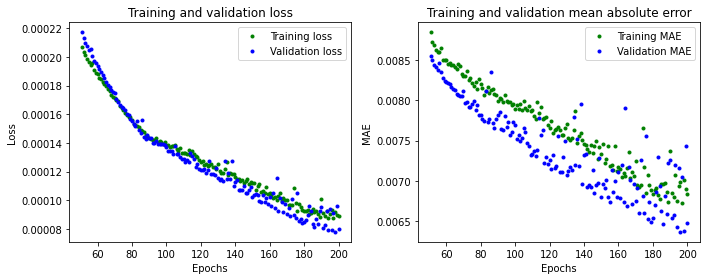

In [163]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

23/23 [==============================] - 0s 964us/step - loss: 8.5742e-05 - mae: 0.0067


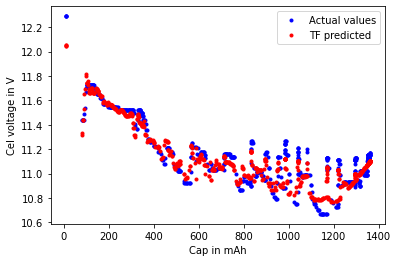

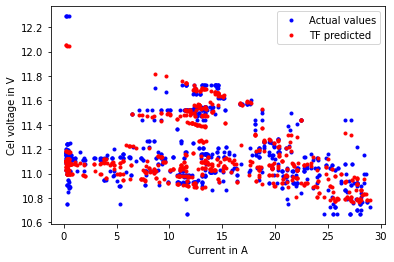

In [173]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Plot vol vs. cap
plt.plot(x_test[:,1]*SCALE_CAP, y_test*SCALE_VOL, 'b.', label='Actual values')
plt.plot(x_test[:,1]*SCALE_CAP, y_test_pred*SCALE_VOL, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cel voltage in V')
plt.show()

# Plot vol vs. cap
plt.plot(x_test[:,0]*SCALE_CUR, y_test*SCALE_VOL, 'b.', label='Actual values')
plt.plot(x_test[:,0]*SCALE_CUR, y_test_pred*SCALE_VOL, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Current in A')
plt.ylabel('Cel voltage in V')
plt.show()

# Real World

the real world problem is to predict the consumed capacity based in integrated current

In [174]:
np.

array([[0.281, 0.924],
       [0.003, 0.984],
       [0.134, 0.345],
       ...,
       [0.254, 0.938],
       [0.002, 1.362],
       [0.111, 0.837]])

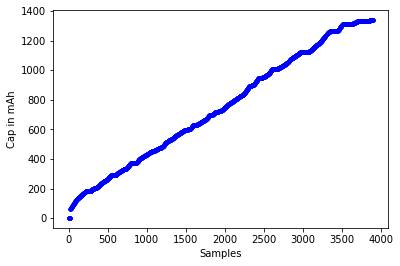

In [ ]:
# my log file contained several flights
#fligth1
INDEX_START=2385
INDEX_STOP=5931

#fligth3
INDEX_START=13006
INDEX_STOP=15521

#fligth2
INDEX_START=6610
INDEX_STOP=10510


#throttle 
x_real=df.iloc[INDEX_START:INDEX_STOP,9]
x_real=x_real.to_numpy()/1000 
#print(x_values)

#current
y_real=df.iloc[INDEX_START:INDEX_STOP,5]
y_real=y_real.to_numpy()/100 
#print(y_values)

#cap(mAh)
y_real2=df.iloc[INDEX_START:INDEX_STOP,6]
y_real2=y_real2.to_numpy()/1000 
#print(y_values2)

# Plot capacity
plt.plot(y_real2*SCALE_CAP, 'b.')
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()



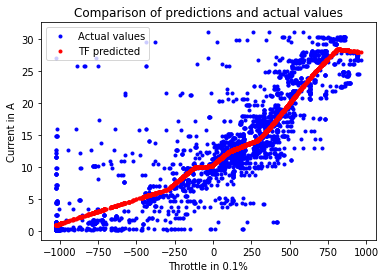

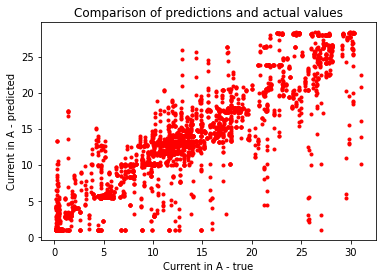

In [ ]:
# Make predictions based on our test dataset
y_real_pred = model.predict(x_real)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_real*SCALE_THROTTLE, y_real*SCALE_CUR, 'b.', label='Actual values')
plt.plot(x_real*SCALE_THROTTLE, y_real_pred*SCALE_CUR, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

plt.title('Comparison of predictions and actual values')
plt.plot(y_real*SCALE_CUR, y_real_pred*SCALE_CUR, 'r.')
plt.xlabel('Current in A - true')
plt.ylabel('Current in A - predicted')
plt.show()

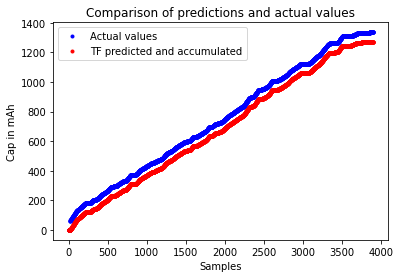

In [ ]:
# integrate current
# offset errors are due to logging only during flight phase (not during take-off)
y_real_pred2=np.cumsum(y_real)*SAMPLE_RATE*1000/3600*SCALE_CUR/SCALE_CAP

plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(y_real2*SCALE_CAP, 'b.', label='Actual values')
plt.plot(y_real_pred2*SCALE_CAP, 'r.', label='TF predicted and accumulated')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()
